In [1]:
import torch
import torchvision
from PIL import Image
import pandas as pd
import pickle
import glob
import os
from torchvision.models import resnet50
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from matplotlib.patches import Rectangle
import cv2


from SimSiam.simsiam.fastsiam import *
from train_fasterrcnn import *

In [2]:
class ZenseactLabeledDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        self.n_samples = len(data)

    def __getitem__(self, index):
        img = self.data[index]["data"]
        boxes = self.data[index]["boxes"]
        labels = self.data[index]["labels"]
        id = self.data[index]["image_id"]
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        return img, target, id
    
    def __len__(self):
        return self.n_samples

In [3]:
def generate_data(df, index):
    data = df[df["id"] == index]

    num_boxes = len(data)

    box_coordinates = []
    for i in range(num_boxes):
        box_coordinates.append(torch.tensor(data.iloc[i][["x_min", "y_min", "x_max", "y_max"]].astype("float").to_numpy()))

    if num_boxes > 1:
        box_coordinates = torch.stack(box_coordinates, axis=0)
    elif num_boxes == 1:
        box_coordinates = box_coordinates[0]
        box_coordinates = box_coordinates.view(1,4)
    else:
        pass

    labels = torch.ones(num_boxes, dtype=torch.int64)

    image_id = data.iloc[0]["image_id"]
    image_path = f"../../../mnt/nfs_mount/single_frames/{image_id}/camera_front_blur/"
    image_path = glob.glob(image_path + "*.jpg")
    image = Image.open(image_path[0]).convert('RGB')

    downsampled_image = image.resize((120, 100))
    transform = transforms.Compose([
                transforms.ToTensor()
            ])

    downsampled_image = transform(downsampled_image)  # Apply the transform

    # stack it to dict
    image_dict = {}
    image_dict["data"] = downsampled_image
    image_dict["boxes"] = box_coordinates
    image_dict["labels"] = labels
    image_dict["image_id"] = index
    return image_dict

In [4]:
def generate_all_data():
    df = pd.read_csv("df_bounding_boxes.csv", dtype=str)
    df["id"] = df["image_id"].astype(int)
    df = df[["id", "image_id", "x_min", "y_min", "x_max", "y_max"]]
    unique_ids = df["id"].unique()     # all ids / indices

    data = []
    for index in unique_ids:
        try:
            data_dict = generate_data(df, index)
            data.append(data_dict)
        except:
            pass

    return data

In [5]:
def get_annotations(id):
    annotation_path = f"../../../mnt/nfs_mount/single_frames/{id}/annotations/object_detection/"
    annotation_file = glob.glob(annotation_path + "*.json")
    f = open(annotation_file[0])
    annotation_list = json.load(f)

    column_names = ['image_id', 'x_min', 'y_min', 'x_max', 'y_max']
    df = pd.DataFrame(columns=column_names)

    # load image to get shape
    image_path = f"../../../mnt/nfs_mount/single_frames/{id}/camera_front_blur/"
    image_files = glob.glob(image_path + "*.jpg")
    if len(image_files) > 0:
        image = Image.open(image_files[0])
    size = image.size

    # only get cars
    for annotation in annotation_list:
        if annotation["properties"]["class"] == "Vehicle":
            # get bounding boxes
            box_coordinates = annotation["geometry"]["coordinates"]

            # Rescale bounding boxes 
            new_size = (120, 100)
            scale_x = new_size[0] / size[0]
            scale_y = new_size[1] / size[1]
            
            min_x = min(coord[0] for coord in box_coordinates) * scale_x
            min_y = min(coord[1] for coord in box_coordinates) * scale_y
            max_x = max(coord[0] for coord in box_coordinates) * scale_x
            max_y = max(coord[1] for coord in box_coordinates) * scale_y

            new_row = {"image_id": id, "x_min": min_x, "y_min": min_y, "x_max": max_x, "y_max": max_y}
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    return df


def create_df_bounding_boxes():
    # The parent directory containing the folders
    parent_directory = "../../../mnt/nfs_mount/single_frames"

    # Find all folders with a 6-digit name
    folder_pattern = os.path.join(parent_directory, "[0-9]" * 6)

    # Get the list of matching folders
    folders = glob.glob(folder_pattern)
    folders = folders[:2] # first 5000 folders

    column_names = ['image_id', 'x_min', 'y_min', 'x_max', 'y_max']
    total_df = pd.DataFrame(columns=column_names)

    # iterate through all folders (009999 etc.)
    for folder in folders:
        id = os.path.basename(folder) # id = foldername
        df = get_annotations(id)
        total_df = pd.concat([total_df, df], ignore_index=True)
    return total_df

In [6]:
# create dataframe
df = create_df_bounding_boxes()

In [7]:
df.to_csv("df_bounding_boxes.csv")

In [8]:
data = generate_all_data()

In [9]:
dataset = ZenseactLabeledDataset(data)

In [10]:
dataset[0]

(tensor([[[0.2627, 0.2824, 0.2863,  ..., 0.4157, 0.4039, 0.3922],
          [0.2588, 0.2667, 0.2824,  ..., 0.4353, 0.4157, 0.3843],
          [0.2745, 0.2627, 0.2196,  ..., 0.4588, 0.4471, 0.3725],
          ...,
          [0.1843, 0.1882, 0.1922,  ..., 0.2784, 0.2745, 0.2706],
          [0.1843, 0.1922, 0.1922,  ..., 0.2745, 0.2745, 0.2706],
          [0.1804, 0.1882, 0.1882,  ..., 0.2745, 0.2706, 0.2667]],
 
         [[0.3333, 0.3647, 0.3647,  ..., 0.4902, 0.4784, 0.4667],
          [0.3255, 0.3451, 0.3647,  ..., 0.5098, 0.4902, 0.4627],
          [0.3529, 0.3412, 0.2588,  ..., 0.5333, 0.5216, 0.4627],
          ...,
          [0.2000, 0.2039, 0.2078,  ..., 0.2941, 0.2902, 0.2902],
          [0.2000, 0.2000, 0.2039,  ..., 0.2941, 0.2902, 0.2863],
          [0.2000, 0.2000, 0.2039,  ..., 0.2902, 0.2863, 0.2863]],
 
         [[0.4078, 0.4431, 0.4510,  ..., 0.5373, 0.5255, 0.5176],
          [0.3882, 0.4196, 0.4392,  ..., 0.5490, 0.5373, 0.5216],
          [0.4314, 0.4078, 0.2824,  ...,

In [11]:
# print bounding boxes to normal image

In [12]:
image_id = "000001"

In [13]:
datapath = f"../../../mnt/nfs_mount/single_frames/{image_id}/"
image_path = f"../../../mnt/nfs_mount/single_frames/{image_id}/camera_front_blur/000001_golf_2021-04-27T10:51:26.001497Z.jpg"
annotation_path = f"../../../mnt/nfs_mount/single_frames/{image_id}/annotations/object_detection/000001_golf_2021-04-27T10:51:26.001497Z.json"

/tmp/ipykernel_2609584/47666952.py:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  downsampled_image = image.resize((120, 100), Image.ANTIALIAS)


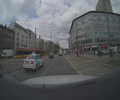

In [14]:
image = Image.open(image_path)
downsampled_image = image.resize((120, 100), Image.ANTIALIAS)
downsampled_image.show()

In [15]:
def visualize_img(id):
    image_path = f"../../../mnt/nfs_mount/single_frames/{id}/camera_front_blur/"
    image_files = glob.glob(image_path + "*.jpg")
    if len(image_files) > 0:
        image = Image.open(image_files[0])
        # image.show()
    return image

In [16]:
def get_annotations(id):
    annotation_path = f"../../../mnt/nfs_mount/single_frames/{id}/annotations/object_detection/"
    annotation_file = glob.glob(annotation_path + "*.json")
    f = open(annotation_file[0])
    annotation_list = json.load(f)

    column_names = ['image_id', 'x_min', 'y_min', 'x_max', 'y_max']
    df = pd.DataFrame(columns=column_names)

    # load image to get shape
    image_path = f"../../../mnt/nfs_mount/single_frames/{id}/camera_front_blur/"
    image_files = glob.glob(image_path + "*.jpg")
    if len(image_files) > 0:
        image = Image.open(image_files[0])
    size = image.size

    # only get cars
    for annotation in annotation_list:
        if annotation["properties"]["class"] == "Vehicle":
            # get bounding boxes
            box_coordinates = annotation["geometry"]["coordinates"]

            # Rescale bounding boxes 
            new_size = (120, 100)
            scale_x = new_size[0] / size[0]
            scale_y = new_size[1] / size[1]
            
            min_x = min(coord[0] for coord in box_coordinates) * scale_x
            min_y = min(coord[1] for coord in box_coordinates) * scale_y
            max_x = max(coord[0] for coord in box_coordinates) * scale_x
            max_y = max(coord[1] for coord in box_coordinates) * scale_y

            new_row = {"image_id": id, "x_min": min_x, "y_min": min_y, "x_max": max_x, "y_max": max_y}
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    return df

In [19]:
def get_annotations_unscaled(id):
    annotation_path = f"../../../mnt/nfs_mount/single_frames/{id}/annotations/object_detection/"
    annotation_file = glob.glob(annotation_path + "*.json")
    f = open(annotation_file[0])
    annotation_list = json.load(f)

    column_names = ['image_id', 'x_min', 'y_min', 'x_max', 'y_max']
    df = pd.DataFrame(columns=column_names)

    # load image to get shape
    image_path = f"../../../mnt/nfs_mount/single_frames/{id}/camera_front_blur/"
    image_files = glob.glob(image_path + "*.jpg")
    if len(image_files) > 0:
        image = Image.open(image_files[0])
    size = image.size

    # only get cars
    for annotation in annotation_list:
        if annotation["properties"]["class"] == "Vehicle":
            # get bounding boxes
            box_coordinates = annotation["geometry"]["coordinates"]

            # Rescale bounding boxes 
            min_x = min(coord[0] for coord in box_coordinates) 
            min_y = min(coord[1] for coord in box_coordinates)
            max_x = max(coord[0] for coord in box_coordinates) 
            max_y = max(coord[1] for coord in box_coordinates) 

            new_row = {"image_id": id, "x_min": min_x, "y_min": min_y, "x_max": max_x, "y_max": max_y}
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    return df

In [20]:
annotation_df = get_annotations(image_id)
annotation_df 

image_id       x_min      y_min       x_max      y_max
0    000001   58.587942  52.306734   59.856861  53.819649
1    000001  103.594491  49.421587  109.471933  54.033210
2    000001   23.053222  52.321033   43.398960  71.438192
3    000001  108.922141  46.754613  116.584927  53.181273
4    000001   92.871830  50.629151   99.174948  54.509225
5    000001   -3.183992  54.113930    3.709771  58.952952
6    000001   66.053950  51.940498   66.621206  52.639760
7    000001   63.297193  50.518911   65.859356  54.678506
8    000001   61.983056  51.192343   64.169751  53.211255
9    000001   54.693555  52.559502   55.152911  53.108856
10   000001  119.271518  49.332103  124.260499  52.928506
11   000001   20.592100  48.565498   29.166736  57.697417
12   000001   52.251767  52.108856   53.686902  53.399446
13   000001   42.879418  50.757380   47.166112  55.063653
14   000001   63.015593  52.305812   64.383992  54.067804
15   000001   66.987006  51.726476   67.546778  52.420203
16   000001   45.467775  50.529059   50.042308  54.592712
17   000001   58.880146  49.335332   62.420582  56.185886
18   000001   40.753222  49.100554   45.866944  55.817804
19   000001  116.341996  49.504613  120.302183  52.639760
20   000001   63.198649  51.046125   65.019231  54.186808
21   000001   51.033056  52.498155   52.431081  53.482934
22   000001   65.588981  51.902214   66.314345  52.670203
23   000001   65.341996  52.046587   66.052079  52.794280
24   000001   62.831913  52.317343   64.038462  53.784594
25   000001    1.279522  49.470018   13.094906  58.880535
26   000001  110.729626  47.522140  117.284719  52.569649
27   000001   25.898545  48.959871   32.864969  57.451568
28   000001   48.886279  53.053506   54.015593  58.339945
29   000001  100.030042  49.402214  108.405405  54.449262
30   000001   57.004366  52.601937   58.716112  54.581181
31   000001  116.340125  49.060424  120.553846  52.085793
32   000001   66.284719  51.880074   66.846362  52.567343
33   000001   33.012474  48.331181   40.383992  57.007841
34   000001   37.193763  48.859317   43.449480  56.242159
35   000001   13.022869  47.957565   23.665385  58.488469

In [21]:
annotation_df = get_annotations_unscaled(image_id)
annotation_df 

image_id    x_min    y_min    x_max    y_max
0    000001  1878.72  1134.01  1919.41  1166.81
1    000001  3321.93  1071.46  3510.40  1171.44
2    000001   739.24  1134.32  1391.66  1548.78
3    000001  3492.77  1013.64  3738.49  1152.97
4    000001  2978.09  1097.64  3180.21  1181.76
5    000001  -102.10  1173.19   118.96  1278.10
6    000001  2118.13  1126.07  2136.32  1141.23
7    000001  2029.73  1095.25  2111.89  1185.43
8    000001  1987.59  1109.85  2057.71  1153.62
9    000001  1753.84  1139.49  1768.57  1151.40
10   000001  3824.64  1069.52  3984.62  1147.49
11   000001   660.32  1052.90   935.28  1250.88
12   000001  1675.54  1129.72  1721.56  1157.70
13   000001  1375.00  1100.42  1512.46  1193.78
14   000001  2020.70  1133.99  2064.58  1172.19
15   000001  2148.05  1121.43  2166.00  1136.47
16   000001  1458.00  1095.47  1604.69  1183.57
17   000001  1888.09  1069.59  2001.62  1218.11
18   000001  1306.82  1064.50  1470.80  1210.13
19   000001  3730.70  1073.26  3857.69  1141.23
20   000001  2026.57  1106.68  2084.95  1174.77
21   000001  1636.46  1138.16  1681.29  1159.51
22   000001  2103.22  1125.24  2126.48  1141.89
23   000001  2095.30  1128.37  2118.07  1144.58
24   000001  2014.81  1134.24  2053.50  1166.05
25   000001    41.03  1072.51   419.91  1276.53
26   000001  3550.73  1030.28  3760.93  1139.71
27   000001   830.48  1061.45  1053.87  1245.55
28   000001  1567.62  1150.20  1732.10  1264.81
29   000001  3207.63  1071.04  3476.20  1180.46
30   000001  1827.94  1140.41  1882.83  1183.32
31   000001  3730.64  1063.63  3865.76  1129.22
32   000001  2125.53  1124.76  2143.54  1139.66
33   000001  1058.60  1047.82  1294.98  1235.93
34   000001  1192.68  1059.27  1393.28  1219.33
35   000001   417.60  1039.72   758.87  1268.03

In [22]:
data = annotation_df
num_boxes = len(data)

box_coordinates = []
for i in range(num_boxes):
    box_coordinates.append(torch.tensor(data.iloc[i][["x_min", "y_min", "x_max", "y_max"]].astype("float").to_numpy()))

if num_boxes > 1:
    box_coordinates = torch.stack(box_coordinates, axis=0)
elif num_boxes == 1:
    box_coordinates = box_coordinates[0]
    box_coordinates = box_coordinates.view(1,4)
else:
    pass
box_coordinates

tensor([[1878.7200, 1134.0100, 1919.4100, 1166.8100],
        [3321.9300, 1071.4600, 3510.4000, 1171.4400],
        [ 739.2400, 1134.3200, 1391.6600, 1548.7800],
        [3492.7700, 1013.6400, 3738.4900, 1152.9700],
        [2978.0900, 1097.6400, 3180.2100, 1181.7600],
        [-102.1000, 1173.1900,  118.9600, 1278.1000],
        [2118.1300, 1126.0700, 2136.3200, 1141.2300],
        [2029.7300, 1095.2500, 2111.8900, 1185.4300],
        [1987.5900, 1109.8500, 2057.7100, 1153.6200],
        [1753.8400, 1139.4900, 1768.5700, 1151.4000],
        [3824.6400, 1069.5200, 3984.6200, 1147.4900],
        [ 660.3200, 1052.9000,  935.2800, 1250.8800],
        [1675.5400, 1129.7200, 1721.5600, 1157.7000],
        [1375.0000, 1100.4200, 1512.4600, 1193.7800],
        [2020.7000, 1133.9900, 2064.5800, 1172.1900],
        [2148.0500, 1121.4300, 2166.0000, 1136.4700],
        [1458.0000, 1095.4700, 1604.6900, 1183.5700],
        [1888.0900, 1069.5900, 2001.6200, 1218.1100],
        [1306.8200, 1064.500

/tmp/ipykernel_2609584/47666952.py:2: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  downsampled_image = image.resize((120, 100), Image.ANTIALIAS)


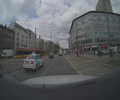

In [23]:
image = Image.open(image_path)
downsampled_image = image.resize((120, 100), Image.ANTIALIAS)
downsampled_image.show()

In [87]:
box_coordinates[0]

tensor([58.5879, 52.3067, 59.8569, 53.8196], dtype=torch.float64)

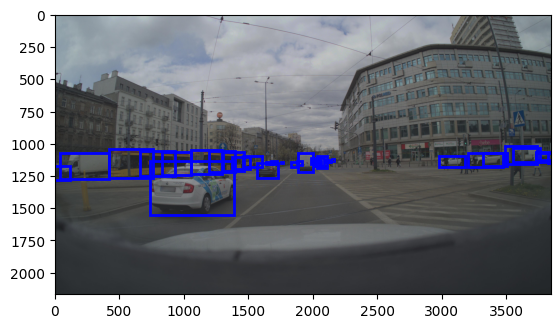

In [24]:
# plot image and box coordinates
plt.imshow(image)

for bbox in box_coordinates:

    min_x = bbox[0]
    min_y = bbox[1]
    max_x = bbox[2]
    max_y = bbox[3]

    width = max_x - min_x
    height = max_y - min_y

    plt.gca().add_patch(Rectangle((min_x, min_y), width, height, edgecolor='b', facecolor='none', linewidth=2))
plt.show()

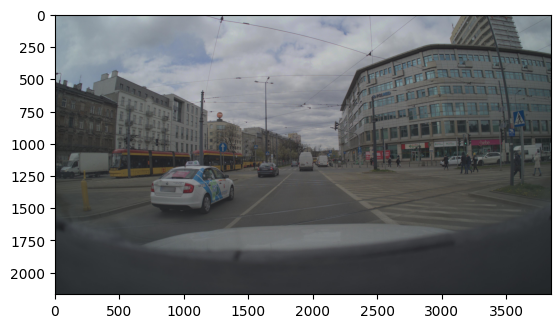

In [18]:

im = cv2.imread(image_path)
#im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [90]:
# use created dataset

In [91]:
data = dataset[1]
data

(tensor([[[0.6000, 0.5725, 0.5725,  ..., 0.5373, 0.5373, 0.5333],
          [0.5882, 0.5686, 0.5686,  ..., 0.5098, 0.5020, 0.5137],
          [0.5882, 0.5725, 0.5765,  ..., 0.4784, 0.4863, 0.4902],
          ...,
          [0.1569, 0.1608, 0.1647,  ..., 0.1412, 0.1412, 0.1412],
          [0.1569, 0.1608, 0.1608,  ..., 0.1412, 0.1412, 0.1373],
          [0.1569, 0.1608, 0.1608,  ..., 0.1373, 0.1373, 0.1373]],
 
         [[0.6706, 0.6392, 0.6392,  ..., 0.5882, 0.5882, 0.5843],
          [0.6588, 0.6314, 0.6275,  ..., 0.5608, 0.5529, 0.5647],
          [0.6588, 0.6392, 0.6353,  ..., 0.5255, 0.5373, 0.5412],
          ...,
          [0.1725, 0.1765, 0.1804,  ..., 0.1569, 0.1569, 0.1569],
          [0.1725, 0.1765, 0.1765,  ..., 0.1569, 0.1569, 0.1529],
          [0.1725, 0.1765, 0.1765,  ..., 0.1529, 0.1529, 0.1529]],
 
         [[0.6980, 0.6706, 0.6667,  ..., 0.6118, 0.6039, 0.5961],
          [0.6863, 0.6627, 0.6627,  ..., 0.5804, 0.5765, 0.5843],
          [0.6863, 0.6706, 0.6667,  ...,

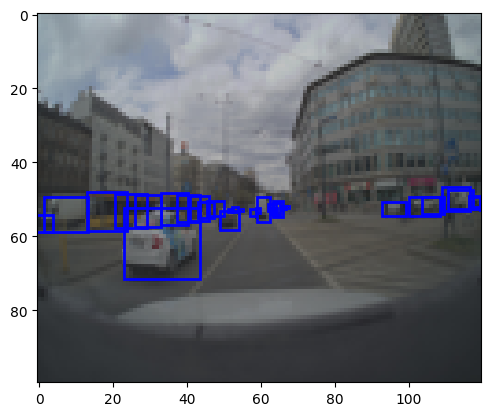

In [92]:
image_tensor = data[0].permute(1, 2, 0)
box_coordinates = data[1]["boxes"]

plt.imshow(image_tensor)

for bbox in box_coordinates:

    min_x = bbox[0]
    min_y = bbox[1]
    max_x = bbox[2]
    max_y = bbox[3]
    width = max_x - min_x
    height = max_y - min_y
    plt.gca().add_patch(Rectangle((min_x, min_y), width, height, edgecolor='b', facecolor='none', linewidth=2))
plt.show()

In [93]:
# trained faster_rcnn
model = create_fasterrcnn("fastsiam.pth")
weights = torch.load("faster_rcnn_fastsiam.pth", map_location=torch.device("cuda"))
model.load_state_dict(weights)

<All keys matched successfully>

In [94]:
test_image = data[0]
test_image

tensor([[[0.6000, 0.5725, 0.5725,  ..., 0.5373, 0.5373, 0.5333],
         [0.5882, 0.5686, 0.5686,  ..., 0.5098, 0.5020, 0.5137],
         [0.5882, 0.5725, 0.5765,  ..., 0.4784, 0.4863, 0.4902],
         ...,
         [0.1569, 0.1608, 0.1647,  ..., 0.1412, 0.1412, 0.1412],
         [0.1569, 0.1608, 0.1608,  ..., 0.1412, 0.1412, 0.1373],
         [0.1569, 0.1608, 0.1608,  ..., 0.1373, 0.1373, 0.1373]],

        [[0.6706, 0.6392, 0.6392,  ..., 0.5882, 0.5882, 0.5843],
         [0.6588, 0.6314, 0.6275,  ..., 0.5608, 0.5529, 0.5647],
         [0.6588, 0.6392, 0.6353,  ..., 0.5255, 0.5373, 0.5412],
         ...,
         [0.1725, 0.1765, 0.1804,  ..., 0.1569, 0.1569, 0.1569],
         [0.1725, 0.1765, 0.1765,  ..., 0.1569, 0.1569, 0.1529],
         [0.1725, 0.1765, 0.1765,  ..., 0.1529, 0.1529, 0.1529]],

        [[0.6980, 0.6706, 0.6667,  ..., 0.6118, 0.6039, 0.5961],
         [0.6863, 0.6627, 0.6627,  ..., 0.5804, 0.5765, 0.5843],
         [0.6863, 0.6706, 0.6667,  ..., 0.5490, 0.5608, 0.

In [95]:
ls = [test_image]
ls[0].shape

torch.Size([3, 100, 120])

In [98]:
model.eval()
output = model(ls)

In [ ]:
detection_threshold = 0.1

with torch.no_grad():
    predictions = model(ls)

    for i, image in enumerate(ls):
        gt_boxes = targets[i]["boxes"].tolist()
        pred_boxes = predictions[i]["boxes"].tolist()
        pred_scores = predictions[i]["scores"].tolist()

        # Apply NMS to filter bounding boxes
        selected_indices = torchvision.ops.nms(torch.tensor(pred_boxes), torch.tensor(pred_scores), detection_threshold)
        pred_boxes = [pred_boxes[i] for i in selected_indices]
        pred_scores = [pred_scores[i] for i in selected_indices]

In [131]:
bounding_boxes = output[0]["boxes"]
bounding_boxes= bounding_boxes.detach().numpy()
bounding_boxes

array([[2.32331772e+01, 5.19906158e+01, 4.30581818e+01, 7.26851807e+01],
       [4.89866447e+01, 5.29149551e+01, 5.39352303e+01, 5.84349365e+01],
       [5.88071556e+01, 4.90734825e+01, 6.21636543e+01, 5.60962029e+01],
       [6.36366959e+01, 5.05003281e+01, 6.59744492e+01, 5.49611053e+01],
       [1.68796730e+00, 4.87564392e+01, 1.35825958e+01, 5.94321747e+01],
       [3.98076859e+01, 4.95629120e+01, 4.67754440e+01, 5.62645187e+01],
       [1.03095589e+02, 4.89448433e+01, 1.08800499e+02, 5.45043068e+01],
       [5.70326691e+01, 5.26774635e+01, 5.83460922e+01, 5.46905785e+01],
       [9.49287033e+01, 4.99977455e+01, 1.00921379e+02, 5.49861183e+01],
       [3.49965057e+01, 4.71350212e+01, 4.44822083e+01, 6.18789711e+01],
       [3.65158157e+01, 4.85998077e+01, 4.36527634e+01, 5.76791840e+01],
       [4.53227234e+01, 5.04060631e+01, 4.80334167e+01, 5.47511864e+01],
       [1.05333633e+02, 4.91594467e+01, 1.10251221e+02, 5.43915176e+01],
       [9.32462769e+01, 5.03140182e+01, 9.89714508e

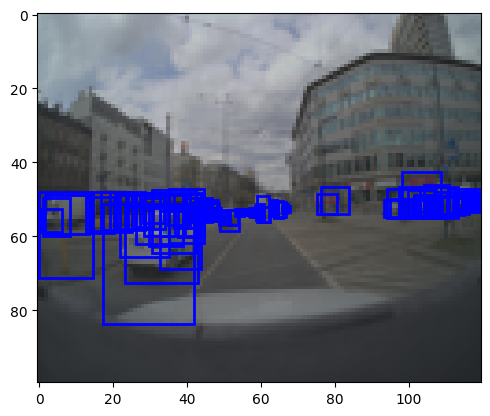

In [132]:
image_tensor = data[0].permute(1, 2, 0)
box_coordinates = bounding_boxes

plt.imshow(image_tensor)

for bbox in box_coordinates:

    min_x = bbox[0]
    min_y = bbox[1]
    max_x = bbox[2]
    max_y = bbox[3]
    width = max_x - min_x
    height = max_y - min_y
    plt.gca().add_patch(Rectangle((min_x, min_y), width, height, edgecolor='b', facecolor='none', linewidth=2))
plt.show()

In [110]:
batch_size = 1
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False, num_workers=0)


detection_threshold = 0.5


model.eval()
device = 'cpu'
results = []
with torch.no_grad():
    for images, targets, id in testloader:    
        try:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)

            for i, image in enumerate(images):

                boxes = outputs[i]['boxes']
                scores = outputs[i]['scores']
                labels = outputs[i]['labels']

                keep = torchvision.ops.nms(boxes, scores, detection_threshold) # the lower, the less we keep
                boxes = boxes[keep]
                scores = scores[keep]
                image_id = id[i]
            
                op = (id[i], boxes, scores)
                results.append(op)
        except Exception as e:
            print(e)

In [111]:
bounding_boxes = results[0][1]
bounding_boxes.shape

torch.Size([100, 4])

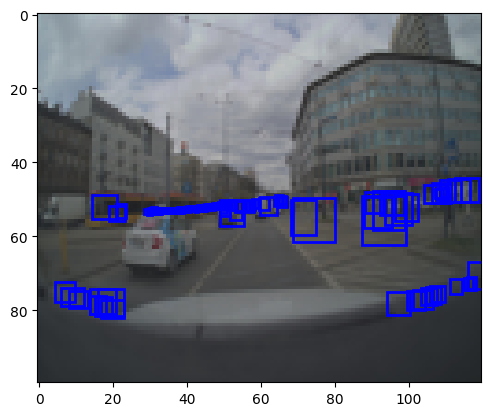

In [112]:
image_tensor = data[0].permute(1, 2, 0)
box_coordinates = bounding_boxes

plt.imshow(image_tensor)

for bbox in box_coordinates:

    min_x = bbox[0]
    min_y = bbox[1]
    max_x = bbox[2]
    max_y = bbox[3]
    width = max_x - min_x
    height = max_y - min_y
    plt.gca().add_patch(Rectangle((min_x, min_y), width, height, edgecolor='b', facecolor='none', linewidth=2))
plt.show()

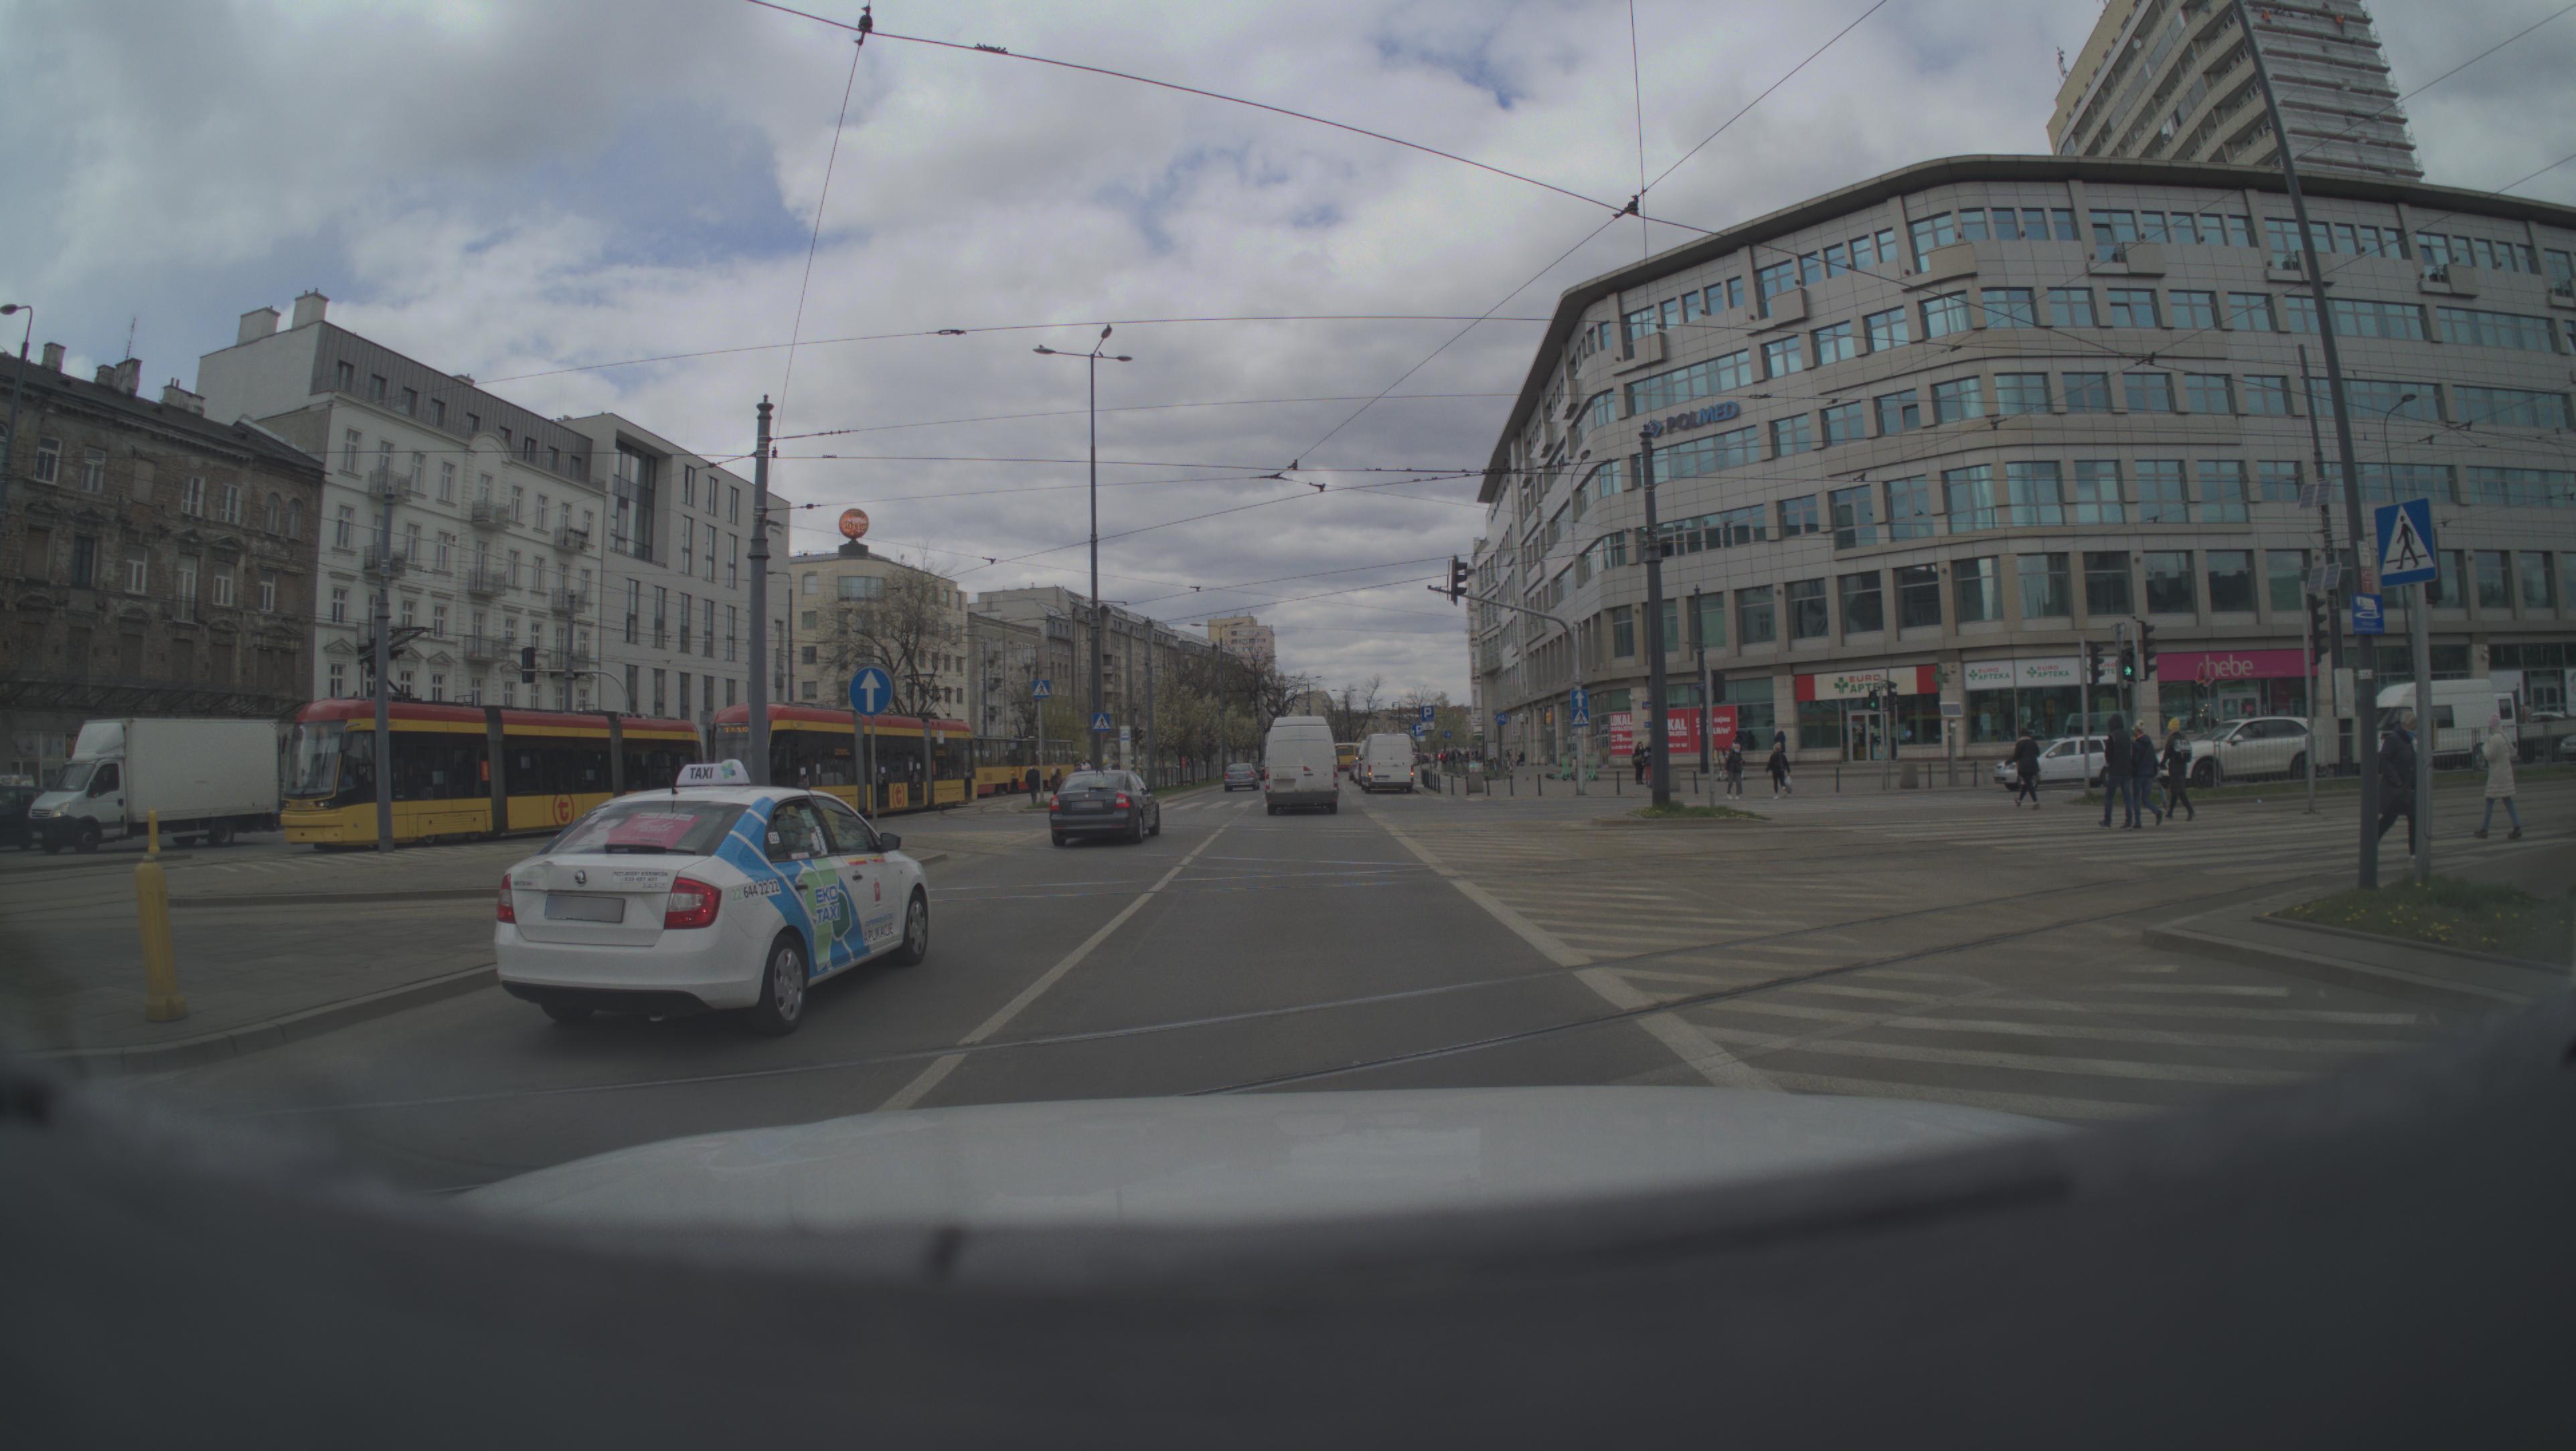

: 

In [133]:
image = Image.open(image_path)
image.show()

In [120]:
dataset[1]

(tensor([[[0.6000, 0.5725, 0.5725,  ..., 0.5373, 0.5373, 0.5333],
          [0.5882, 0.5686, 0.5686,  ..., 0.5098, 0.5020, 0.5137],
          [0.5882, 0.5725, 0.5765,  ..., 0.4784, 0.4863, 0.4902],
          ...,
          [0.1569, 0.1608, 0.1647,  ..., 0.1412, 0.1412, 0.1412],
          [0.1569, 0.1608, 0.1608,  ..., 0.1412, 0.1412, 0.1373],
          [0.1569, 0.1608, 0.1608,  ..., 0.1373, 0.1373, 0.1373]],
 
         [[0.6706, 0.6392, 0.6392,  ..., 0.5882, 0.5882, 0.5843],
          [0.6588, 0.6314, 0.6275,  ..., 0.5608, 0.5529, 0.5647],
          [0.6588, 0.6392, 0.6353,  ..., 0.5255, 0.5373, 0.5412],
          ...,
          [0.1725, 0.1765, 0.1804,  ..., 0.1569, 0.1569, 0.1569],
          [0.1725, 0.1765, 0.1765,  ..., 0.1569, 0.1569, 0.1529],
          [0.1725, 0.1765, 0.1765,  ..., 0.1529, 0.1529, 0.1529]],
 
         [[0.6980, 0.6706, 0.6667,  ..., 0.6118, 0.6039, 0.5961],
          [0.6863, 0.6627, 0.6627,  ..., 0.5804, 0.5765, 0.5843],
          [0.6863, 0.6706, 0.6667,  ...,